In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Data_Cortex_Nuclear.csv')  

In [3]:
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [4]:
t = pd.Series(df.isna().sum())
t[t>100]

BAD_N        213
BCL2_N       285
H3AcK18_N    180
EGR1_N       210
H3MeK4_N     270
dtype: int64

В нашем датасете есть колонки (признаки), где отонсительно большое число пропусков (больше 180 при том, что всего 1080 строк). Это признаки: 'BAD_N', 'BCL2_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N'. Удалим эти колонки из нашего рассмотрения.

In [5]:
df.drop(columns=['BAD_N', 'BCL2_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N'],inplace=True)

In [6]:
len(t[(t>0) & (t < 100)])

44

In [7]:
len(df['MouseID'].unique())==len(df['MouseID'])

True

В строках также обнаружены пропуски (44 строки с небольшим количество пропусков в каждрй), их мы удалим (Заполнение их чем-то в данном случае трудно обосновать, но таких пропусков относительно мало).

Колонку MouseID можно удалить, так это просто нумерация для датасета. Так как id нигде не повторяется, делаем вывод что здесь нет измерении для одной и той же мыши, т.е. этот признак можно отбросить.

In [8]:
df.dropna(inplace=True)
df.drop(columns=['MouseID'],inplace=True)

In [9]:
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,pCFOS_N,SYP_N,CaNA_N,Genotype,Treatment,Behavior,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,0.339571,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.106305,0.108336,0.427099,1.675652,Control,Memantine,C/S,c-CS-m
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,0.321959,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.106592,0.104315,0.441581,1.743610,Control,Memantine,C/S,c-CS-m
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,0.313086,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.108303,0.106219,0.435777,1.926427,Control,Memantine,C/S,c-CS-m
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,0.328492,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.103184,0.111262,0.391691,1.700563,Control,Memantine,C/S,c-CS-m
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,0.312206,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.481227,0.251773,1.534835,2.009109,0.119524,0.997775,0.878668,0.205604,0.104784,0.110694,0.434154,1.839730,Control,Memantine,C/S,c-CS-m


In [10]:
df.select_dtypes(exclude=['int', 'float']).columns

Index(['Genotype', 'Treatment', 'Behavior', 'class'], dtype='object')

In [14]:
df.shape

(972, 76)

В нашем датасете есть 4 колонки с категориальными данными: 'Genotype', 'Treatment', 'Behavior', 'class'
Первые три переведем в числовое представление с помощью OneHotEncoder, метки класса просто занумеруем с помощью LabelEncoder 

In [15]:
from sklearn.preprocessing import LabelEncoder
df = pd.get_dummies(df, columns=['Genotype', 'Treatment', 'Behavior'])
enc = LabelEncoder()
df['class'] = enc.fit_transform(df['class'])

In [17]:
df["class"].value_counts()

2    150
6    135
4    120
3    120
1    120
0    120
7    117
5     90
Name: class, dtype: int64

Количество элементов выборки по классам не совсем сбалансированно.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N
0,0.503644,0.747193,0.430175,2.816329
1,0.514617,0.689064,0.411770,2.789514
2,0.509183,0.730247,0.418309,2.687201
3,0.442107,0.617076,0.358626,2.466947
4,0.434940,0.617430,0.358802,2.365785
...,...,...,...,...
1075,0.254860,0.463591,0.254860,2.092082
1076,0.272198,0.474163,0.251638,2.161390
1077,0.228700,0.395179,0.234118,1.733184
1078,0.221242,0.412894,0.243974,1.876347


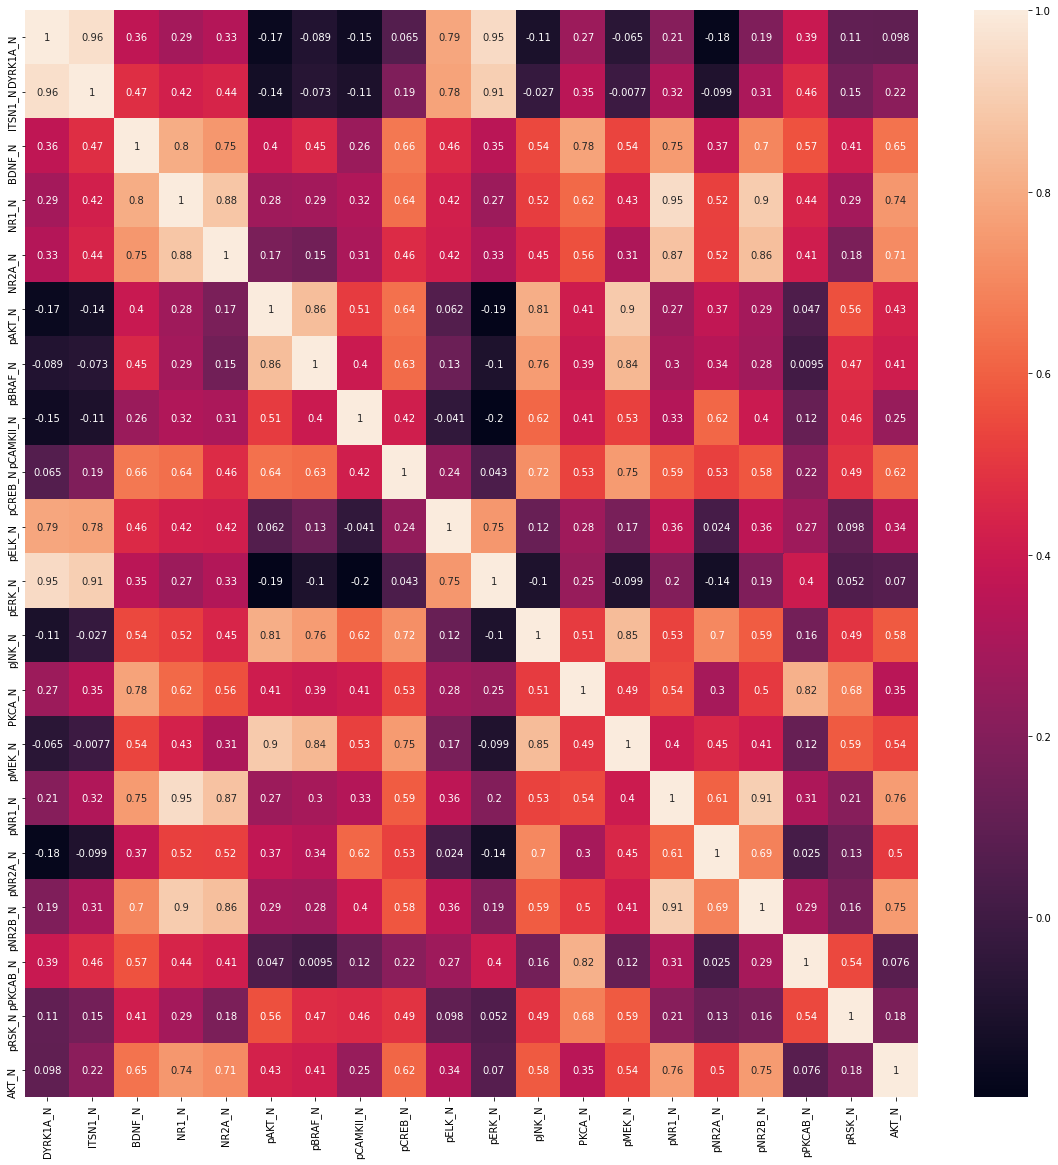

In [33]:
plt.figure(figsize = (20,20))
corr = df[df.columns[[i for i in range(20)]]].corr()
sns.heatmap(corr, annot = True)

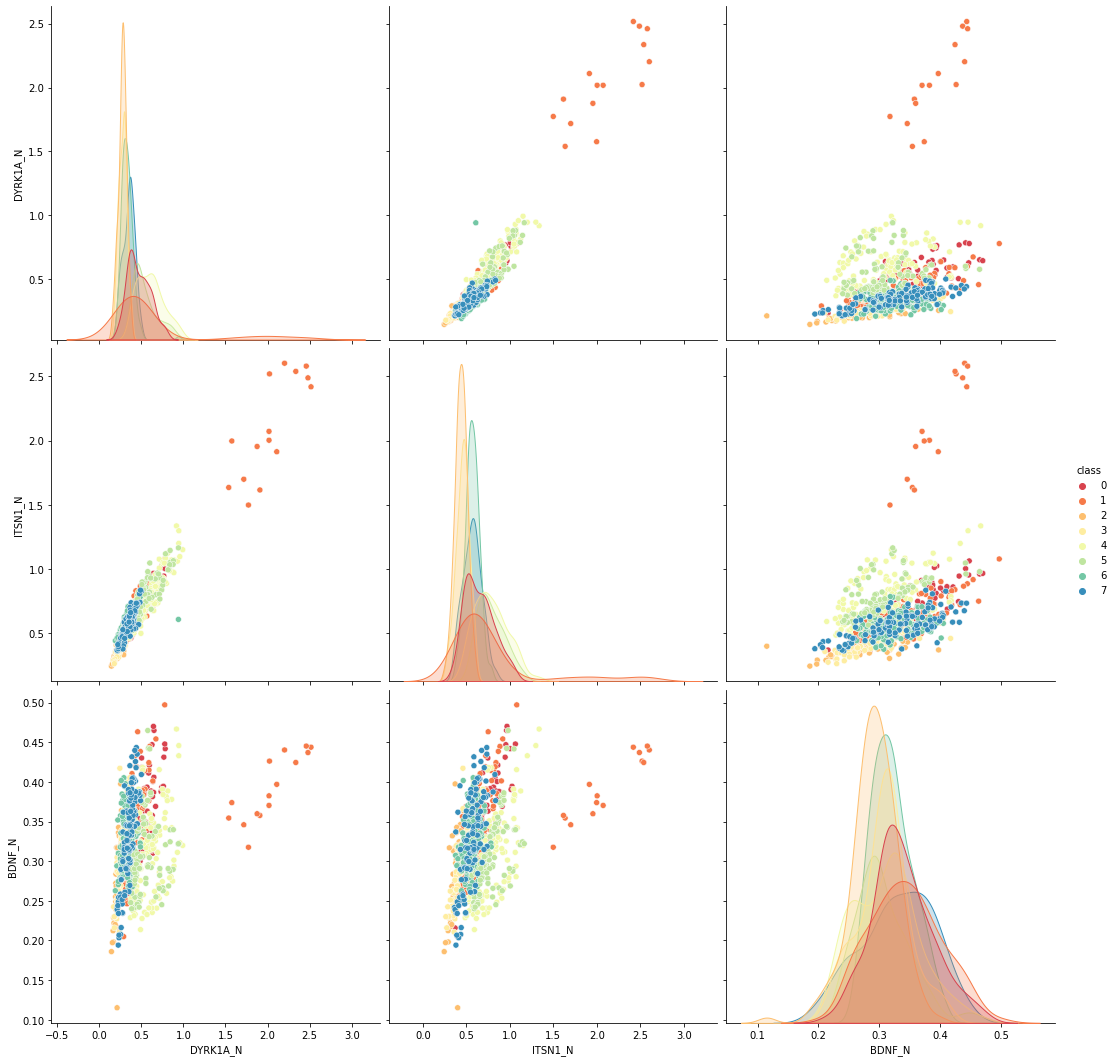

In [105]:
sns.pairplot(t, hue='class', palette=sns.color_palette("Spectral", n_colors=8),height=5)

In [97]:
t = df[df.columns[[i for i in range(3)]]].merge(df['class'],left_index=True, right_index=True)

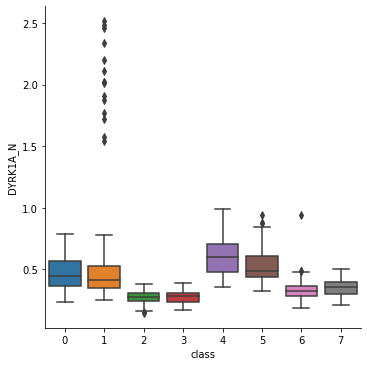

In [39]:
sns.catplot(x="class", y="DYRK1A_N", kind="box", data=df)

In [ ]:
import ipywidgets
from IPython.display import clear_output


In [81]:
def draw_box_plot_per_class(col_i):
  clear_output()
  sns.catplot(x="class", y=df.columns[col_i], kind="box", data=df)

In [83]:
ipywidgets.interact(draw_box_plot_per_class, col_i = [i for i in range(72)])

interactive(children=(Dropdown(description='col_i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [ ]:
# Load the iris dataset
iris = datasets.load_iris()

# Create our X and y data
X = iris.data
y = iris.target
y[:5]
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [ ]:
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# Train the scaler, which standarizes all the features to have mean=0 and unit variance
sc = StandardScaler()
sc.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

In [ ]:
# Create a perceptron object with the parameters: 40 iterations (epochs) over the data, and a learning rate of 0.1
ppn = Perceptron( max_iter = 350,eta0=0.00001,tol=None, penalty='l2')

# Train the perceptron
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1e-05,
           fit_intercept=True, max_iter=350, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=None,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Apply the trained perceptron on the X data to make predicts for the y test data
y_pred = ppn.predict(X_test_std)
# View the accuracy of the model, which is: 1 - (observations predicted wrong / total observations)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.96


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.98


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential()
model.add(Dense(3, input_shape=(4,),activation='softmax'))
#model.add(Activation('softmax'))

In [ ]:
from keras.optimizers import SGD

In [ ]:

sgd = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform( y_train.reshape(-1, 1))

In [ ]:
y

In [ ]:
X_train_std.shape

(105, 4)

In [ ]:
model.fit(X_train_std,y,epochs=200, validation_split=0.1)

y_pred = model.predict_classes(X_test_std)

Epoch 1/200
3/3 [==============================] - 0s 56ms/step - loss: 1.4387 - accuracy: 0.1489 - val_loss: 1.3915 - val_accuracy: 0.0909
Epoch 2/200
3/3 [==============================] - 0s 7ms/step - loss: 1.3936 - accuracy: 0.1596 - val_loss: 1.3476 - val_accuracy: 0.0909
Epoch 3/200
3/3 [==============================] - 0s 8ms/step - loss: 1.3508 - accuracy: 0.1915 - val_loss: 1.3058 - val_accuracy: 0.0909
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 1.3105 - accuracy: 0.2021 - val_loss: 1.2660 - val_accuracy: 0.1818
Epoch 5/200
3/3 [==============================] - 0s 7ms/step - loss: 1.2720 - accuracy: 0.2340 - val_loss: 1.2283 - val_accuracy: 0.1818
Epoch 6/200
3/3 [==============================] - 0s 8ms/step - loss: 1.2351 - accuracy: 0.2553 - val_loss: 1.1924 - val_accuracy: 0.1818
Epoch 7/200
3/3 [==============================] - 0s 7ms/step - loss: 1.2006 - accuracy: 0.2660 - val_loss: 1.1583 - val_accuracy: 0.2727
Epoch 8/200
3/3 [=========

In [ ]:
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.91


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
